<a href="https://colab.research.google.com/github/jeffblackadar/image_work/blob/master/Categorized_E_II_G_VI_Lincoln_k_fold_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# From: https://github.com/spmallick/learnopencv/blob/master/KerasCNN-CIFAR/keras-cnn-cifar10.ipynb
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import print_function
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, InputLayer
from keras.utils import to_categorical

Using TensorFlow backend.


# Copy images into train, validation and test directories
This only needs to be run once.
20 Images training
10 validation

In [0]:
# Thanks to
# https://thispointer.com/python-how-to-get-list-of-files-in-directory-and-sub-directories/
def getListOfFiles(dirName):
    import os
    # create a list of file and sub directories 
    # names in the given directory 
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        if os.path.isdir(fullPath):
            #allFiles = allFiles + getListOfFiles(fullPath)
            print(fullPath)
        else:
            allFiles.append(entry)
            #print(entry)    
    return allFiles 


In [0]:
#Move images
def copy_images(original_dataset_dir, portrait_image_prefix, train_portrait_dir, validation_portrait_dir, test_portrait_dir):
    #run it once time for each class of images
    import os, shutil

    list_of_files = getListOfFiles(original_dataset_dir)
    print(len(list_of_files))
    # adjust the ranges based on how the images should be split.
    # an equal number per class is required.
    #train
    for i in range(0,37):
        src = os.path.join(original_dataset_dir, list_of_files[i])
        if os.path.exists(src):
            dst = os.path.join(train_portrait_dir, list_of_files[i])
            shutil.copyfile(src, dst)

    #validation
    for i in range(37,55):
        src = os.path.join(original_dataset_dir, list_of_files[i])
        if os.path.exists(src):
            dst = os.path.join(validation_portrait_dir, list_of_files[i])
            shutil.copyfile(src, dst)

    #test
    for i in range(55,73):
        src = os.path.join(original_dataset_dir, list_of_files[i])
        if os.path.exists(src):
            dst = os.path.join(test_portrait_dir, list_of_files[i])
            shutil.copyfile(src, dst)


In [0]:
import os
base_dir = '/content/drive/My Drive/coin-image-processor/portraits'
if not os.path.exists(base_dir):
    os.mkdir(base_dir)

#make each directory for the types of images
train_dir = os.path.join(base_dir, 'train')
if not os.path.exists(train_dir):
    os.mkdir(train_dir)

validation_dir = os.path.join(base_dir, 'validation')
if not os.path.exists(validation_dir):
    os.mkdir(validation_dir)

test_dir = os.path.join(base_dir, 'test')
if not os.path.exists(test_dir):
    os.mkdir(test_dir)

portrait = 'all'

#make each sub-directory
train_portrait_dir = os.path.join(train_dir, portrait)
if not os.path.exists(train_portrait_dir):
    os.mkdir(train_portrait_dir)

validation_portrait_dir = os.path.join(validation_dir, portrait)
if not os.path.exists(validation_portrait_dir):
    os.mkdir(validation_portrait_dir)

test_portrait_dir = os.path.join(test_dir, portrait)
if not os.path.exists(test_portrait_dir):
    os.mkdir(test_portrait_dir)
    
    
#copy_images('/content/drive/My Drive/coin-image-processor/photos/elizabeth_young', 'eII', train_portrait_dir, validation_portrait_dir, test_portrait_dir)
#copy_images('/content/drive/My Drive/coin-image-processor/photos/george_vi', 'gvi', train_portrait_dir, validation_portrait_dir, test_portrait_dir)
copy_images('/content/drive/My Drive/coin-image-processor/photos/lincoln', 'lin', train_portrait_dir, validation_portrait_dir, test_portrait_dir)

print(train_portrait_dir)
print('total training portrait images:', len(os.listdir(train_portrait_dir)))
print(validation_portrait_dir)
print('total validation portrait images:', len(os.listdir(validation_portrait_dir)))
print(test_portrait_dir)
print('total test portrait images:', len(os.listdir(test_portrait_dir)))


88
/content/drive/My Drive/coin-image-processor/portraits/train/all
total training portrait images: 111
/content/drive/My Drive/coin-image-processor/portraits/validation/all
total validation portrait images: 54
/content/drive/My Drive/coin-image-processor/portraits/test/all
total test portrait images: 54


Set up Training, Testing, Validation images.
one_hot_label them:
1,0 = Elizabeth II
0,1 = George VI


In [3]:
#https://blog.francium.tech/build-your-own-image-classifier-with-tensorflow-and-keras-dc147a15e38e
  
import cv2
import numpy as np
import os
from random import shuffle
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

#This controls how much of the image resolution is input into the model.  I have used 128 as values but I believe that contributes to overfitting.
image_width=64
image_height=64

train_data = "/content/drive/My Drive/coin-image-processor/portraits/train/all"
test_data = "/content/drive/My Drive/coin-image-processor/portraits/test/all"
validation_data = "/content/drive/My Drive/coin-image-processor/portraits/validation/all"

def one_hot_label(img):
    label = img.split('.')[0]
    label = label[:3]
    if label == 'eII':
        ohl = np.array([1,0,0])
    elif label == 'gvi':
        ohl = np.array([0,1,0])
    elif label == 'lin':
        ohl = np.array([0,0,1])
    return ohl

def train_data_with_label():
    train_images = []
    print("*** Train ***")
    for i in tqdm(os.listdir(train_data)):
        path = os.path.join(train_data, i)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (image_width, image_height))
        #plt.imshow(img)
        #print(path)
        #print(one_hot_label(i))
        train_images.append([np.array(img), one_hot_label(i)])
        shuffle(train_images)
    return train_images

def test_data_with_label():
    print("*** Test ***")
    test_images = []
    for i in tqdm(os.listdir(test_data)):
        path = os.path.join(test_data, i)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)        
        img = cv2.resize(img, (image_width, image_height))
        #plt.imshow(img)
        #print(path)
        #print(one_hot_label(i))
        test_images.append([np.array(img), one_hot_label(i)])
        #shuffle(test_images)
    return test_images

def validation_data_with_label():
    print("*** Validation ***")
    validation_images = []
    for i in tqdm(os.listdir(validation_data)):
        path = os.path.join(validation_data, i)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)        
        img = cv2.resize(img, (image_width, image_height))
        #plt.imshow(img)
        #print(path)
        #print(one_hot_label(i))
        validation_images.append([np.array(img), one_hot_label(i)])
        #shuffle(validation_images)
    return validation_images
  
  
  
training_images = train_data_with_label()
print(str(len(training_images))+" Training Images")
testing_images = test_data_with_label()
print(str(len(testing_images))+" Testing Images")
validation_images = validation_data_with_label()
print(str(len(validation_images))+" Validation Images")
tr_img_data = np.array([i[0] for i in training_images]).reshape(-1,image_width, image_height,1)
tr_lbl_data = np.array([i[1] for i in training_images])
tst_img_data = np.array([i[0] for i in testing_images]).reshape(-1,image_width, image_height,1)
tst_lbl_data = np.array([i[1] for i in testing_images])
val_img_data = np.array([i[0] for i in validation_images]).reshape(-1,image_width, image_height,1)
val_lbl_data = np.array([i[1] for i in validation_images])

*** Train ***


100%|██████████| 111/111 [01:26<00:00,  1.33it/s]


111 Training Images
*** Test ***


100%|██████████| 54/54 [00:26<00:00,  3.78it/s]


54 Testing Images
*** Validation ***


100%|██████████| 54/54 [00:25<00:00,  2.50it/s]

54 Validation Images


In [0]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
#         zoom_range=0.2, # randomly zoom into images
#         rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        #width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        #height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        #horizontal_flip=True,  # randomly flip images
        #vertical_flip=False)  # randomly flip images


    rescale=1./255,
    shear_range=0.05,
    zoom_range=0.25,
    fill_mode = "nearest",    
    width_shift_range=0.05,
    height_shift_range=0.05,
    rotation_range=20,
    horizontal_flip=False)

num_val_samples 27
processing fold # 0
length partial_train_data 84
Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_65 (Conv2D)           (None, 64, 64, 32)        832       
_________________________________________________________________
max_pooling2d_65 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 32, 32, 32)        25632     
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_65 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_33 (Flatten)         (None, 8192)              0         
___________________________________________________

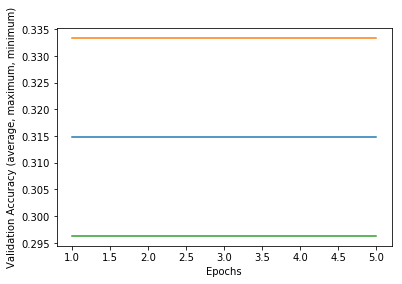

In [17]:
from keras.regularizers import Regularizer
from keras.regularizers import l2

def createModel3():
    model = Sequential()
    
    model.add(InputLayer(input_shape=(image_width, image_height,1)))
    
    model.add(Conv2D(filters=32,kernel_size=5,strides=1,padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    #model.add(Dropout(0.50))
    
    model.add(Conv2D(filters=32,kernel_size=5,strides=1,padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    #model.add(Dropout(0.25))
              
    #model.add(Conv2D(filters=64,kernel_size=5,strides=1,padding='same', activation='relu'))
    #model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    #model.add(Dropout(0.25))
    
    #model.add(Conv2D(filters=128,kernel_size=5,strides=1,padding='same', activation='relu'))
    #model.add(MaxPooling2D(pool_size=(1,1), padding='same'))
    
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))
    #number of classes
    # 1,0,0 E-II
    # 0,1,0 G-VI
    # 0,0,1 G-VI
    model.add(Dense(3, activation='softmax'))

    return model


def build_model():
    model = Sequential()
    
    model.add(InputLayer(input_shape=(image_width, image_height,1)))
    
    model.add(Conv2D(filters=32,kernel_size=5,strides=1,padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    
    model.add(Conv2D(filters=32,kernel_size=5,strides=1,padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))
    #number of classes
    # 1,0,0 E-II
    # 0,1,0 G-VI
    # 0,0,1 G-VI
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

    return model
    
  

#model2 = createModel3()
#model2.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
#model2.summary()

#batch_size = 31
#epochs = 50

# datagen.fit(train_data)
#it doesn't make sense we mix test and validation

# Fit the model on the batches generated by datagen.flow().

#history2 = model2.fit_generator(datagen.flow(tr_img_data , tr_lbl_data, batch_size=batch_size),
#                              #steps_per_epoch=int(np.ceil(tr_img_data .shape[0] / float(batch_size))),
#                              steps_per_epoch=31,
#                              epochs=epochs,
#                              validation_data=(val_img_data, val_lbl_data),
#                              #validation_split=0.3,
#                              validation_steps=10,
#                              shuffle=True,
#                              workers=4)

#model2.evaluate(tst_img_data, tst_lbl_data)


#*********************
#* Use K-Fold validation
#*********************
import numpy as np

k = 4
num_val_samples = len(training_images) // k
print("num_val_samples "+ str(num_val_samples))
num_epochs = 5
#all_scores = []
#history2 = []
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    val_data = tr_img_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = tr_lbl_data[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(
        [tr_img_data[:i * num_val_samples],
         tr_img_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [tr_lbl_data[:i * num_val_samples],
         tr_lbl_data[(i + 1) * num_val_samples:]],
        axis=0)
    print("length partial_train_data "+ str(len(partial_train_data)))
    
    
    #model = build_model()
    model = createModel3()
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    history = model.fit(partial_train_data, partial_train_targets,
              validation_data=(val_data, val_targets),
              #          validation_split=0.33,
              epochs=num_epochs, batch_size=3, verbose=0)
    
    
                        
    
    #history2.append(history)
    #val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=1)
    
    #all_scores.append(val_mae)
    history_dict = history.history
    print(history_dict.keys())
    mae_history = history.history['val_acc']
    all_mae_histories.append(mae_history)


average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
max_mae_history = [
    np.max([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
min_mae_history = [
    np.min([x[i] for x in all_mae_histories]) for i in range(num_epochs)]


#Listing 3.30. Plotting validation scores
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.plot(range(1, len(max_mae_history) + 1), max_mae_history)
plt.plot(range(1, len(min_mae_history) + 1), min_mae_history)

plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy (average, maximum, minimum)')
plt.show()

#fit(self, x=None, y=None, batch_size=None, epochs=1, verbose=1, callbacks=None, 
#validation_split=0.0, validation_data=None, shuffle=True, class_weight=None, sample_weight=None, 
#initial_epoch=0, steps_per_epoch=None, validation_steps=None)

In [0]:
plt.figure(figsize=[8,6])
plt.plot(history2.history['loss'],'r',linewidth=3.0)
plt.plot(history2.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

AttributeError: ignored

<Figure size 576x432 with 0 Axes>

In [0]:
plt.figure(figsize=[8,6])
plt.plot(history2.history['acc'],'r',linewidth=3.0)
plt.plot(history2.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

AttributeError: ignored

<Figure size 576x432 with 0 Axes>

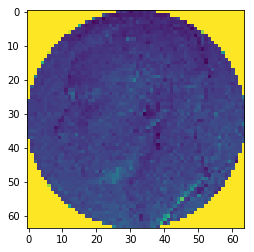

[[0. 1. 0.]]


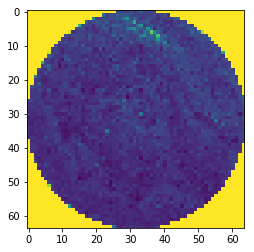

[[0. 1. 0.]]


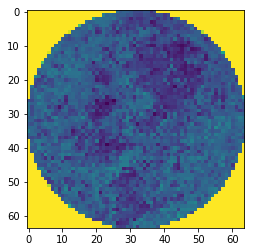

[[0. 1. 0.]]


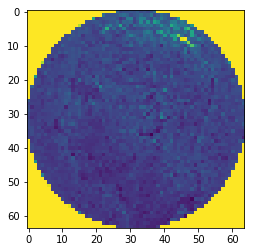

[[0. 1. 0.]]


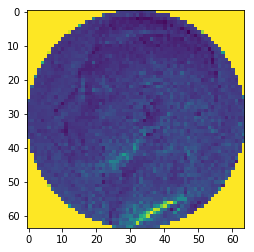

[[0. 1. 0.]]


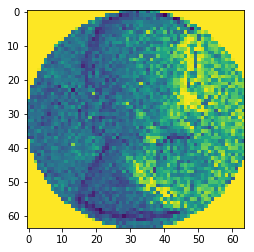

[[0. 1. 0.]]


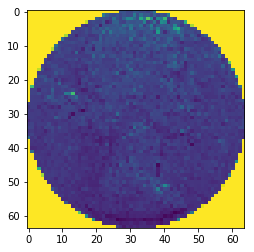

[[0. 1. 0.]]


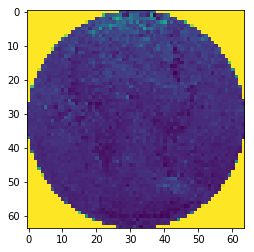

[[0. 1. 0.]]


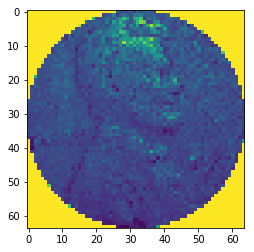

[[0. 1. 0.]]


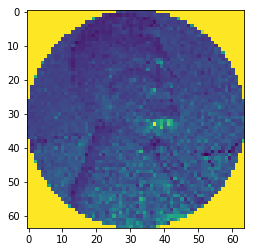

[[0. 1. 0.]]


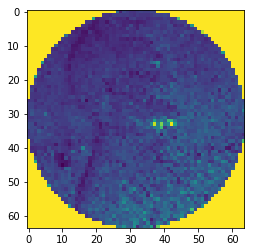

[[0. 1. 0.]]


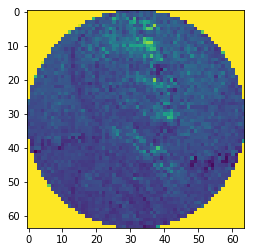

[[0. 1. 0.]]


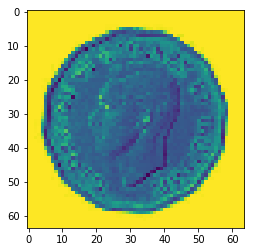

[[0. 1. 0.]]


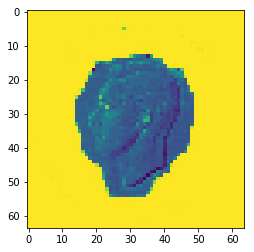

[[0. 1. 0.]]


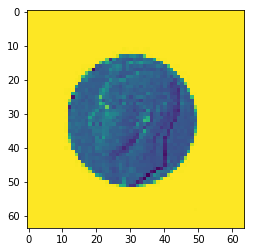

[[0. 1. 0.]]
Does it make a difference to make this larger 300X311


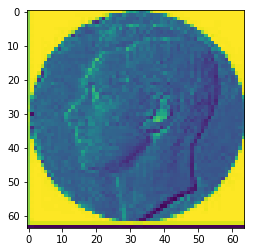

[[0. 1. 0.]]


In [0]:
model2=model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
import numpy as np

#from keras.models import load_model
#model_final = load_model('/content/portrait_model.h5')

#function that reads image, shows it on screen and makes a prediction


def predict_for(img_name):
    #load image from file - VGG16 takes (244,244) input
    #myimg = load_img(img_name, target_size=(300,300))
    myimg = cv2.imread(img_name, cv2.IMREAD_GRAYSCALE)        
    myimg = cv2.resize(myimg, (image_width, image_height))
    plt.imshow(myimg)
    plt.show()

    #convert image pixels to array
    myimg = img_to_array(myimg)
    myimg = np.expand_dims(myimg, axis=0)
    # prepare image for the VGG model
    #myimg = preprocess_input(myimg)
    #predict probability for all 1000 classes
    pred=int(model2.predict(myimg)[0][0])
    print(model2.predict(myimg))
    #print('Prediction for %s: %s'%(img_name, class_names[pred]))

predict_for('/content/drive/My Drive/coin-image-processor/portraits/test/george_vi/gvi3490.png')
predict_for('/content/drive/My Drive/coin-image-processor/portraits/test/george_vi/gvi3491.png')
predict_for('/content/drive/My Drive/coin-image-processor/portraits/test/george_vi/gvi3500.png')
predict_for('/content/drive/My Drive/coin-image-processor/portraits/test/george_vi/gvi3511.png')
predict_for('/content/drive/My Drive/coin-image-processor/photos/george_vi/gvi3330.png')
predict_for('/content/drive/My Drive/coin-image-processor/photos/elizabeth_young/eII2903.png')
predict_for('/content/drive/My Drive/coin-image-processor/portraits/test/all/eII3211.png')
predict_for('/content/drive/My Drive/coin-image-processor/portraits/test/all/eII3172.png')
predict_for('/content/drive/My Drive/coin-image-processor/portraits/test/all/linc4361.png')
predict_for('/content/drive/My Drive/coin-image-processor/portraits/test/all/linc4400.png')
predict_for('/content/drive/My Drive/coin-image-processor/portraits/test/all/linc4430.png')
predict_for('/content/drive/My Drive/coin-image-processor/portraits/test/all/linc4351.png')
#predict_for('')

predict_for('/content/drive/My Drive/coin-image-processor/gvi_test_full.jfif')
predict_for('/content/drive/My Drive/coin-image-processor/gvi_test_roughcrop.jpg')
predict_for('/content/drive/My Drive/coin-image-processor/gvi_test_roundcrop.jpg')
print('Does it make a difference to make this larger 300X311')
predict_for('/content/drive/My Drive/coin-image-processor/george_vi_round_crop_300.jpg')
